In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder as ohe, MinMaxScaler as mms

from catboost import CatBoostRegressor as cat
from lightgbm import LGBMRegressor as lgbm

plt.rc('font', family='Malgun Gothic')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

In [3]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv').drop('ID',axis=1)
submission = pd.read_csv('./open/sample_submission.csv')

In [4]:
train['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    train.loc[train[col]==1,'연료'] = col
train = train.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

test['연료'] = 0
for col in tqdm(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)']):
    test.loc[test[col]==1,'연료'] = col
test = test.drop(['압축천연가스(CNG)','경유','가솔린','하이브리드','액화석유가스(LPG)'],axis=1)

100%|██████████| 5/5 [00:00<00:00, 1250.31it/s]


In [5]:
lst = []
for val in tqdm(train['배기량']):
    if val > 2000:
        lst.append('대형')
    elif val > 1600:
        lst.append('중형')
    elif val > 1000:
        lst.append('소형')
    else:
        lst.append('경형')

train['배기량별 구분'] = lst

100%|██████████| 57920/57920 [00:00<00:00, 4408487.06it/s]


In [6]:
lst = []
for val in tqdm(test['배기량']):
    if val > 2000:
        lst.append('대형')
    elif val > 1600:
        lst.append('중형')
    elif val > 1000:
        lst.append('소형')
    else:
        lst.append('경형')

test['배기량별 구분'] = lst

100%|██████████| 14480/14480 [00:00<00:00, 4081828.21it/s]


In [7]:
train['연간 자동차세'] = 0
train.loc[train['배기량별 구분']=='경형','연간 자동차세'] = train['배기량'] * 90
train.loc[train['배기량별 구분']=='소형','연간 자동차세'] = train['배기량'] * 140
train.loc[np.logical_or(train['배기량별 구분']=='중형', train['배기량별 구분']=='대형'),'연간 자동차세'] = train['배기량'] * 220

test['연간 자동차세'] = 0
test.loc[test['배기량별 구분']=='경형','연간 자동차세'] = test['배기량'] * 90
test.loc[test['배기량별 구분']=='소형','연간 자동차세'] = test['배기량'] * 140
test.loc[np.logical_or(test['배기량별 구분']=='중형', test['배기량별 구분']=='대형'),'연간 자동차세'] = test['배기량'] * 220

train['지방교육세'] = train['연간 자동차세'] * .3
test['지방교육세'] = test['연간 자동차세'] * .3

In [8]:
train['총 자동차세'] = train['연간 자동차세'] + train['지방교육세']
test['총 자동차세'] = test['연간 자동차세'] + test['지방교육세']

In [9]:
lst = []
for val in tqdm(train['배기량']):
    if val > 3800:
        lst.append('8기통')
    elif val > 3000:
        lst.append('6기통')
    elif val > 1400:
        lst.append('4기통')
    else:
        lst.append('3기통')

train['배기량별 구분2'] = lst

100%|██████████| 57920/57920 [00:00<00:00, 4497446.82it/s]


In [10]:
lst = []
for val in tqdm(test['배기량']):
    if val > 3800:
        lst.append('8기통')
    elif val > 3000:
        lst.append('6기통')
    elif val > 1400:
        lst.append('4기통')
    else:
        lst.append('3기통')

test['배기량별 구분2'] = lst

100%|██████████| 14480/14480 [00:00<00:00, 4836626.74it/s]


In [11]:
train['생산이후'] = 2023 - train['생산년도']
train['모델출시이후'] = 2023 - train['모델출시년도']

test['생산이후'] = 2023 - test['생산년도']
test['모델출시이후'] = 2023 - test['모델출시년도']

In [12]:
train['자동차세 할인 여부'] = 0
train.loc[train['생산이후']>=3,'자동차세 할인 여부'] = 1

test['자동차세 할인 여부'] = 0
test.loc[test['생산이후']>=3,'자동차세 할인 여부'] = 1

train['할인 후 자동차세'] = 0
train.loc[train['생산이후']>=3,'할인 후 자동차세'] = (train['연간 자동차세'] + train['지방교육세'])*(1 - (train['생산이후']-2)*.05)
train.loc[train['생산이후']>=13,'할인 후 자동차세'] = (train['연간 자동차세'] + train['지방교육세'])*.5

test['할인 후 자동차세'] = 0
test.loc[test['생산이후']>=3,'할인 후 자동차세'] = (test['연간 자동차세'] + test['지방교육세'])*(1 - (test['생산이후']-2)*.05)
test.loc[test['생산이후']>=13,'할인 후 자동차세'] = (test['연간 자동차세'] + test['지방교육세'])*.5

In [13]:
train['일반보증'] = 0
train.loc[np.logical_or(train['생산이후']<=3, train['주행거리']<=60000),'일반보증'] = 1

test['일반보증'] = 0
test.loc[np.logical_or(test['생산이후']<=3, test['주행거리']<=60000),'일반보증'] = 1

train['엔진보증'] = 0
train.loc[np.logical_or(train['생산이후']<=5, train['주행거리']<=100000),'엔진보증'] = 1

test['엔진보증'] = 0
test.loc[np.logical_or(test['생산이후']<=5, test['주행거리']<=100000),'엔진보증'] = 1

In [14]:
train.head()

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,가격,연료,...,연간 자동차세,지방교육세,총 자동차세,배기량별 구분2,생산이후,모델출시이후,자동차세 할인 여부,할인 후 자동차세,일반보증,엔진보증
0,2018,2014,skoda,fabia,KAT,SLA,85231,999,51.74,가솔린,...,89910,26973.0,116883.0,3기통,5,9,1,99350.55,0,1
1,2010,2006,toyota,auris,RKO,SWI,135000,1598,41.47,가솔린,...,223720,67116.0,290836.0,4기통,13,17,1,145418.00,0,0
2,2002,2002,mercedes-benz,clk-klasa,GNI,WIE,255223,1796,17.81,가솔린,...,395120,118536.0,513656.0,4기통,21,21,1,256828.00,0,0
3,2006,2001,nissan,x-trail,EHX,WIE,238000,2184,18.20,경유,...,480480,144144.0,624624.0,4기통,17,22,1,312312.00,0,0
4,2007,2007,fiat,bravo,OSW,MAL,251000,1910,17.55,경유,...,420200,126060.0,546260.0,4기통,16,16,1,273130.00,0,0


In [24]:
rank1 = train['브랜드'].value_counts(ascending=True).index.to_list()
rank2 = train['차량모델명'].value_counts(ascending=True).index.to_list()
rank3 = train['판매도시'].value_counts(ascending=True).index.to_list()
rank4 = train['판매구역'].value_counts(ascending=True).index.to_list()

In [25]:
rank_1 = {}
rank_2 = {}
rank_3 = {}
rank_4 = {}

for i in range(len(rank1)):
    key = rank1[i]
    value = i
    rank_1[key] = value

for i in range(len(rank2)):
    key = rank2[i]
    value = i
    rank_2[key] = value

for i in range(len(rank3)):
    key = rank3[i]
    value = i
    rank_3[key] = value

for i in range(len(rank4)):
    key = rank4[i]
    value = i
    rank_4[key] = value

In [28]:
train['브랜드'] = train['브랜드'].map(rank_1)
train['차량모델명'] = train['차량모델명'].map(rank_2)
train['판매도시'] = train['판매도시'].map(rank_3)
train['판매구역'] = train['판매구역'].map(rank_4)

In [31]:
train

,생산년도,모델출시년도,브랜드,차량모델명,판매도시,판매구역,주행거리,배기량,가격,연료,...,연간 자동차세,지방교육세,총 자동차세,배기량별 구분2,생산이후,모델출시이후,자동차세 할인 여부,할인 후 자동차세,일반보증,엔진보증
0,2018,2014,12,127,3217,15,85231,999,51.74,가솔린,...,89910,26973.0,116883.0,3기통,5,9,1,99350.55,0,1
1,2010,2006,13,114,935,5,135000,1598,41.47,가솔린,...,223720,67116.0,290836.0,4기통,13,17,1,145418.00,0,0
2,2002,2002,11,47,3207,14,255223,1796,17.81,가솔린,...,395120,118536.0,513656.0,4기통,21,21,1,256828.00,0,0
3,2006,2001,10,57,3085,14,238000,2184,18.20,경유,...,480480,144144.0,624624.0,4기통,17,22,1,312312.00,0,0
4,2007,2007,3,70,3023,13,251000,1910,17.55,경유,...,420200,126060.0,546260.0,4기통,16,16,1,273130.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57915,2017,2011,11,81,3219,14,64839,1461,116.87,경유,...,204540,61362.0,265902.0,4기통,6,12,1,212721.60,0,1
57916,2006,2005,19,110,3170,7,299850,1796,15.47,가솔린,...,395120,118536.0,513656.0,4기통,17,18,1,256828.00,0,0
57917,2013,2003,3,48,3125,16,112000,1368,21.97,가솔린,...,191520,57456.0,248976.0,3기통,10,20,1,149385.60,0,0
57918,2006,2004,19,142,3131,12,189321,1598,16.77,가솔린,...,223720,67116.0,290836.0,4기통,17,19,1,145418.00,0,0


In [26]:
rank_1

{'mitsubishi': 0,
 'peugeot': 1,
 'citroen': 2,
 'fiat': 3,
 'volvo': 4,
 'honda': 5,
 'mazda': 6,
 'seat': 7,
 'hyundai': 8,
 'kia': 9,
 'nissan': 10,
 'mercedes-benz': 11,
 'skoda': 12,
 'toyota': 13,
 'renault': 14,
 'bmw': 15,
 'audi': 16,
 'volkswagen': 17,
 'ford': 18,
 'opel': 19}

In [16]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()

ValueError: could not convert string to float: 'skoda'

<Figure size 800x800 with 0 Axes>

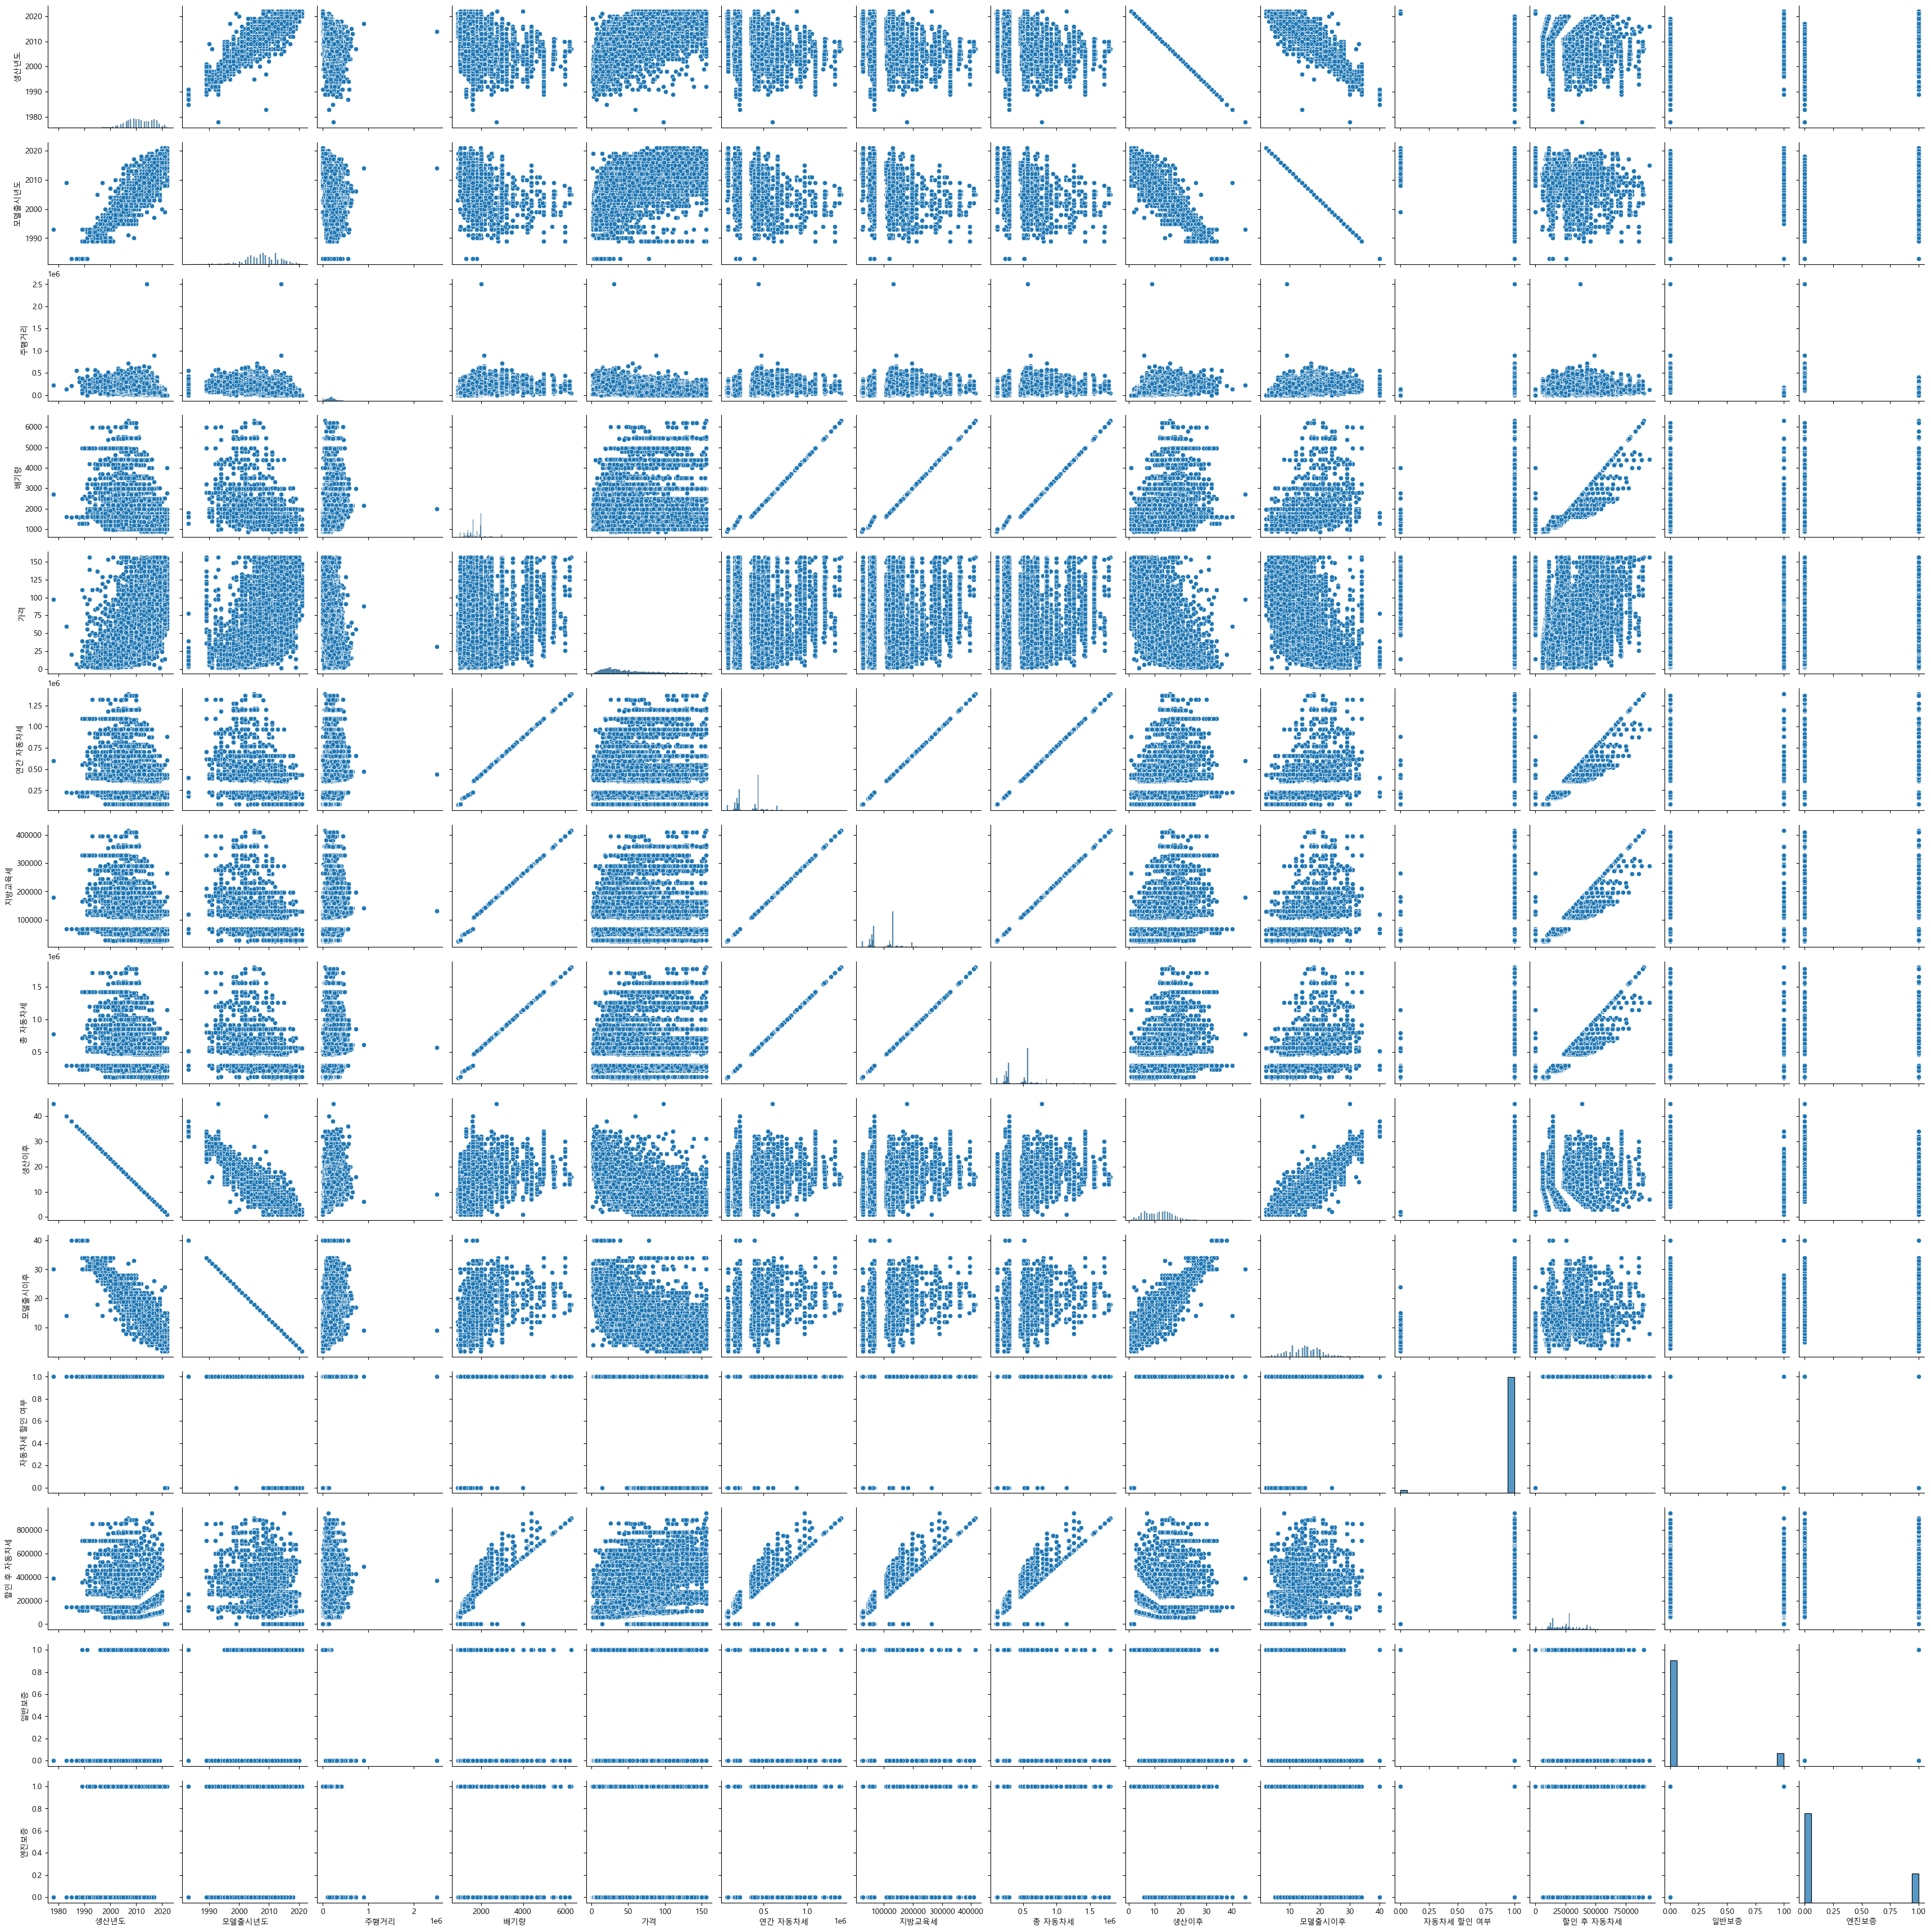

In [15]:
sns.pairplot(train)

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(train.corr(), annot = True, cmap = 'Blues')
plt.show()